In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Фиксируем seed для воспроизводимости
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f"Device: {device}")

Device: cuda


# Задание 1
В этом задании вам нужно будет подобрать архитектуру нейронной сети, чтобы пробить порог в 80% accuracy

In [2]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=4, persistent_workers=True, generator=torch.Generator().manual_seed(42))

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=4, persistent_workers=True, generator=torch.Generator().manual_seed(42))


/home/vladg00dman/Projects/Olympiads/ARSO_AI_practise/.venv/lib/python3.14/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [3]:
for i, _ in trainloader:
    print(i[0].shape)
    break

torch.Size([3, 32, 32])


In [4]:
# ==========================================
# ВАША АРХИТЕКТУРА (TODO)
# ==========================================

class MySuperCNN(nn.Module):
    def __init__(self):
        super(MySuperCNN, self).__init__()
        
        # ------------------------------------------------------------------
        # TODO: Определите слои вашей модели здесь
        # Подсказка: Используйте nn.Sequential, nn.Conv2d, nn.BatchNorm2d, nn.ReLU, nn.MaxPool2d
        # Пример: 
        # self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # ------------------------------------------------------------------
        
        layers = [
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),

            nn.Linear(64 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        ]

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # ------------------------------------------------------------------
        # TODO: Опишите прямой проход
        # Не забудьте про flatten перед полносвязными слоями: x = x.view(x.size(0), -1)
        # ------------------------------------------------------------------
        
        return self.net(x)


In [5]:
model = MySuperCNN().to(device)

num_params = sum(p.numel() for p in model.parameters())
print(f"Количество параметров: {num_params:,}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Количество параметров: 2,400,586


In [6]:
def train_loop(model, epochs=10):
    best_acc = 0.0
    
    for epoch in tqdm(range(epochs)):
        model.train()
        running_loss = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Валидация в конце эпохи
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(trainloader):.4f} | Val Acc: {val_acc:.2f}%")
        
        if val_acc > best_acc:
            best_acc = val_acc

    return best_acc


In [7]:
final_acc = train_loop(model, epochs=10) 

print(f"\nИтоговая точность: {final_acc:.2f}%")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 | Loss: 1.4448 | Val Acc: 60.69%
Epoch 2/10 | Loss: 1.0114 | Val Acc: 67.91%
Epoch 3/10 | Loss: 0.8439 | Val Acc: 74.12%
Epoch 4/10 | Loss: 0.7562 | Val Acc: 75.15%
Epoch 5/10 | Loss: 0.6898 | Val Acc: 75.02%
Epoch 6/10 | Loss: 0.6454 | Val Acc: 75.93%
Epoch 7/10 | Loss: 0.6029 | Val Acc: 77.63%
Epoch 8/10 | Loss: 0.5649 | Val Acc: 77.43%
Epoch 9/10 | Loss: 0.5296 | Val Acc: 81.02%
Epoch 10/10 | Loss: 0.4978 | Val Acc: 81.84%

Итоговая точность: 81.84%


In [8]:
# Проверка результата
assert final_acc > 80.0, "Точность ниже 80%. Попробуйте добавить слоев, BatchNorm или увеличить ширину сети!"
print("Отличная работа! Тест пройден.")

Отличная работа! Тест пройден.


# Задание 2

In [77]:
class FixedCNN(nn.Module):
    def __init__(self):
        super(FixedCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2, 2), # 16x16
            
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2, 2), # 8x8
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Настройки обучения
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
# Фиксированная статистика нормализации для CIFAR-10
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [78]:
# Функция для запуска эксперимента
def run_experiment(name, train_transform, epochs=10):
    print(f"\n=== Запуск эксперимента: {name} ===")
    
    # Тестовый трансформ всегда фиксирован (только нормализация)
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*stats)
    ])
    
    # Загрузка данных
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=4, persistent_workers=True, generator=torch.Generator().manual_seed(42))
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=4, persistent_workers=True, generator=torch.Generator().manual_seed(42))
    
    # Реинициализация модели
    model = FixedCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    train_accs = []
    val_accs = []
    
    for epoch in range(epochs):
        model.train()
        correct_train = 0
        total_train = 0
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()
            
        train_acc = 100 * correct_train / total_train
        train_accs.append(train_acc)
        
        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()
        
        val_acc = 100 * correct_val / total_val
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}: Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
        
    return train_accs, val_accs

In [87]:
# ЗАДАЙТЕ ТРИ СТРАТЕГИИ АУГМЕНТАЦИИ

# Стратегия 1: Baseline (ТолькоToTensor + Normalize). Должен быть сильный переобуч.
transforms_baseline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# Стратегия 2: "Вредные" аугментации. 
# Попробуйте то, что ломает семантику (RandomVerticalFlip, слишком сильный Jitter, Invert и т.д.)
transforms_bad = transforms.Compose([
    # TODO: Добавьте сюда плохие аугментации
    transforms.RandomVerticalFlip(p=1.0), # Пример: переворачиваем машины вверх колесами
    transforms.ColorJitter(brightness=1, contrast=1, saturation=1, hue=0.5),
    transforms.ColorJitter(brightness=1, contrast=1, saturation=1, hue=0.5),
    transforms.ColorJitter(brightness=1, contrast=1, saturation=1, hue=0.5),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# Стратегия 3: "Идеальные" аугментации.
# Попробуйте RandomHorizontalFlip, RandomSizedCrop, RandomRotation и т.д.
transforms_best = transforms.Compose([
    # TODO: Добавьте сюда хорошие аугментации
    # transforms.RandomHorizontalFlip(),
    # ...
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.Normalize(*stats)
])

## ВИЗУАЛИЗАЦИЯ (Обязательно посмотрите, что вы скармливаете сети!)

/home/vladg00dman/Projects/Olympiads/ARSO_AI_practise/.venv/lib/python3.14/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


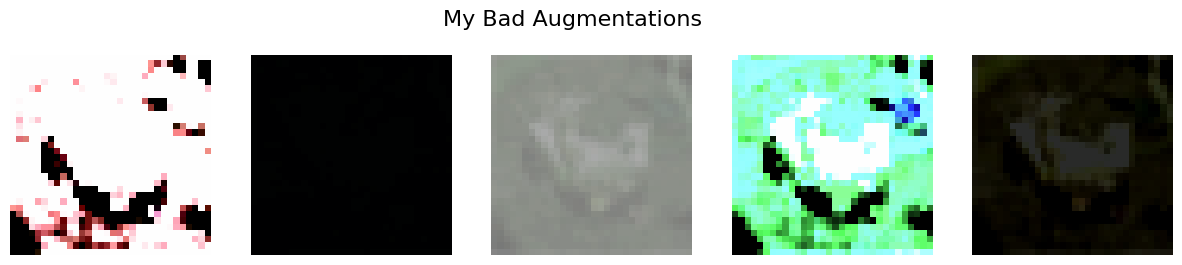

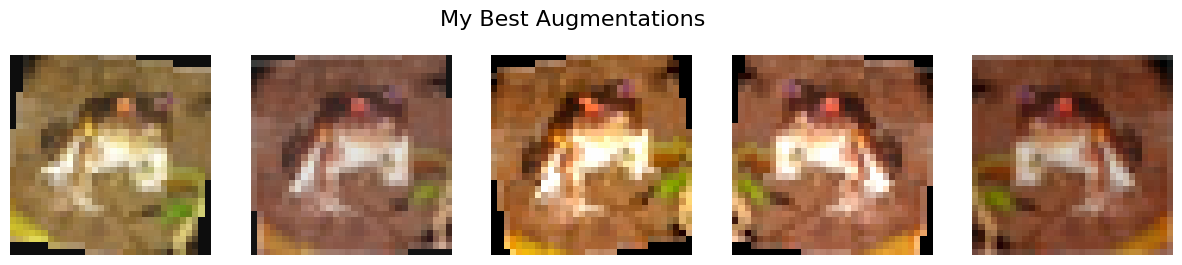

In [88]:
def show_aug(transform, title):
    # Берем чистую картинку
    raw_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
    img = raw_set.data[0] # Картинка numpy array
    img_pil = transforms.ToPILImage()(img)
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(title, fontsize=16)
    for i in range(5):
        # Применяем трансформ (нужно убрать Normalize для визуализации, чтобы цвета не поплыли)
        # Это хак для визуализации, в реальном обучении Normalize нужен
        aug_img = transform(img_pil)
        
        # Если трансформ вернул Tensor, переводим обратно для показа
        if isinstance(aug_img, torch.Tensor):
             # Denormalize вручную для показа, если там был Normalize
             aug_img = aug_img.permute(1, 2, 0).numpy()
             aug_img = (aug_img * stats[1]) + stats[0] # un-normalize
             aug_img = np.clip(aug_img, 0, 1)
             
        axes[i].imshow(aug_img)
        axes[i].axis('off')
    plt.show()

# Эта функция покажет, как transforms_best меняют одну и ту же лягушку
# (Уберите нормализацию из transforms_best временно или создайте копию для визуализации без неё)
show_aug(transforms_bad, "My Bad Augmentations")
show_aug(transforms_best, "My Best Augmentations")

In [89]:
# 1. Запуск Baseline
train_base, val_base = run_experiment("Baseline (No Augs)", transforms_baseline, epochs=10)

# 2. Запуск Bad
train_bad, val_bad = run_experiment("Bad Augmentations", transforms_bad, epochs=10)

# 3. Запуск Best
train_best, val_best = run_experiment("Best Augmentations", transforms_best, epochs=10)


=== Запуск эксперимента: Baseline (No Augs) ===
Epoch 1: Train Acc: 44.78% | Val Acc: 58.26%
Epoch 2: Train Acc: 65.12% | Val Acc: 67.76%
Epoch 3: Train Acc: 73.62% | Val Acc: 71.20%
Epoch 4: Train Acc: 77.81% | Val Acc: 74.72%
Epoch 5: Train Acc: 81.26% | Val Acc: 75.66%
Epoch 6: Train Acc: 83.95% | Val Acc: 78.23%
Epoch 7: Train Acc: 86.33% | Val Acc: 79.31%
Epoch 8: Train Acc: 88.87% | Val Acc: 79.54%
Epoch 9: Train Acc: 90.58% | Val Acc: 78.24%
Epoch 10: Train Acc: 92.37% | Val Acc: 78.65%

=== Запуск эксперимента: Bad Augmentations ===
Epoch 1: Train Acc: 12.25% | Val Acc: 11.04%
Epoch 2: Train Acc: 19.28% | Val Acc: 16.14%
Epoch 3: Train Acc: 28.37% | Val Acc: 21.93%
Epoch 4: Train Acc: 36.32% | Val Acc: 25.07%
Epoch 5: Train Acc: 42.09% | Val Acc: 28.17%
Epoch 6: Train Acc: 45.32% | Val Acc: 26.76%
Epoch 7: Train Acc: 47.45% | Val Acc: 28.37%
Epoch 8: Train Acc: 49.78% | Val Acc: 26.69%
Epoch 9: Train Acc: 51.04% | Val Acc: 27.41%
Epoch 10: Train Acc: 51.84% | Val Acc: 26.15%



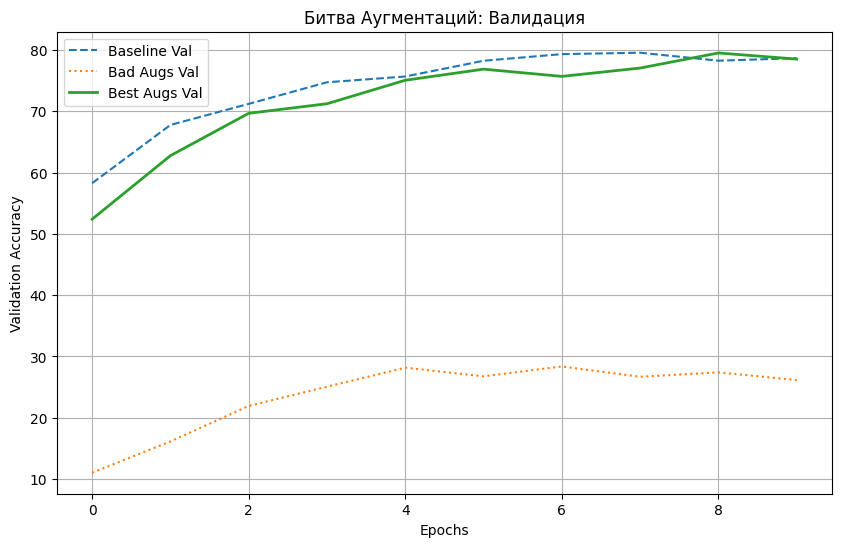

Final Best Val Acc: 78.50%


In [90]:
plt.figure(figsize=(10, 6))
plt.plot(val_base, label='Baseline Val', linestyle='--')
plt.plot(val_bad, label='Bad Augs Val', linestyle=':')
plt.plot(val_best, label='Best Augs Val', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Битва Аугментаций: Валидация')
plt.legend()
plt.grid()
plt.show()

print(f"Final Best Val Acc: {val_best[-1]:.2f}%")